In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from torch import autograd


from sklearn.decomposition import PCA

In [26]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T

#data pre-processing
scaler1 = StandardScaler()
# scaler2 = MaxAbsScaler()
# scaler = MaxAbsScaler()
data_standard = scaler1.fit_transform(data)
# data_standard = scaler2.fit_transform(data_standard)

#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

In [27]:
data

array([[  14.96,   41.76, 1024.07,   73.17],
       [  25.18,   62.96, 1020.04,   59.08],
       [   5.11,   39.4 , 1012.16,   92.14],
       ...,
       [  31.32,   74.33, 1012.92,   36.48],
       [  24.48,   69.45, 1013.86,   62.39],
       [  21.6 ,   62.52, 1017.23,   67.87]])

# Neural Network

In [28]:
x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
n_train = y_train.shape[0]
n_test = y_test.shape[0]
y_ts=y_ts.reshape(n_train,1)
y_test_ts = y_test_ts.reshape(n_test,1)
x=Variable(x_ts)

In [29]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(4,8) 
        self.linear2 = torch.nn.Linear(8,6)
        self.predict = torch.nn.Linear(6,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()
model_pca = Model().double()

model

Model(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [30]:
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []
for epoch in range(3000):
    # forward
    y_pred = model(x)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_list.append(epoch)
    l_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    # updating parameters
    optimizer.step()

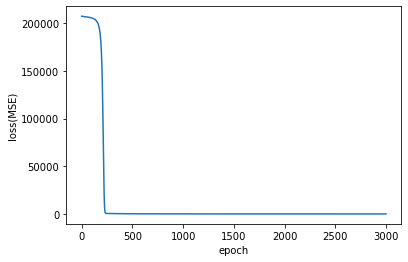

In [31]:
plt.plot(h_list, l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.9209858663998419
MSE is 22.31626058739867


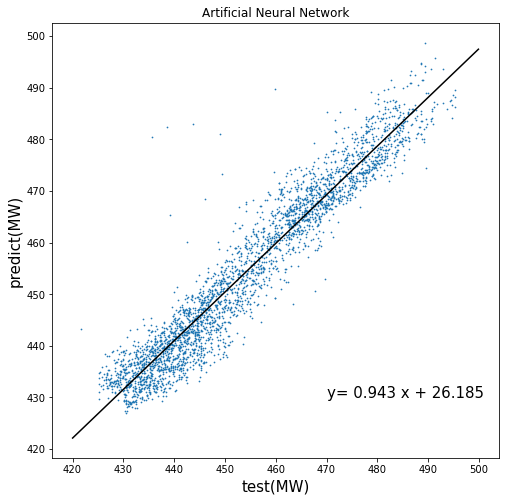

In [32]:
y_test_model=model(x_test_ts)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,y_predict,s=0.5)

z5 = np.polyfit(y_test,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_test,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

# Jacobian-based attack

In [33]:
def Jacobian_attack(model,x_test,y_test,x_adv,perturbation,target_score):
    n_iter = 100
    n = 0
    theta = 0.001
#     gradient = torch.zeros_like(x_test)
#     x_adv = x_test + theta*gradient
#     Variable(x_adv)
    y_adv = model(x_adv)
    

    input_noise = np.linalg.norm(x_adv.detach().numpy()-x_test.detach().numpy())/np.linalg.norm(x_test.detach().numpy())
    r2_adv = r2_score(y_adv.detach().numpy(),y_test)
    while input_noise<perturbation  and r2_adv>target_score and n<n_iter:
#         x_adv.requires_grad=True
        x_adv.retain_grad()
        y_adv = model(x_adv)
        y_adv.sum().backward()
        gradient = x_adv.grad
#         print( x_adv.grad)
        input_noise = np.linalg.norm(x_adv.detach().numpy()-x_test.detach().numpy())/np.linalg.norm(x_test.detach().numpy())
        r2_adv = r2_score(y_adv.detach().numpy(),y_test)
        x_adv = x_adv + theta * gradient
        n = n+1
    return input_noise,r2_adv

In [34]:
x_test_ts=torch.from_numpy(X_test)

perturbation = 1
targ_list = [0.9,0.8,0.7,0.6,0.5]
x_adv = x_test_ts
x_adv.requires_grad=True
perturb_list = []
target_list = []

for tar in targ_list:
    input_noise,r2_adv = Jacobian_attack(model,x_test_ts,y_test,x_adv,perturbation,tar)
    perturb_list.append(input_noise)
    target_list.append(r2_adv)

print(perturb_list)
print(target_list)


[0.06897392325938105, 0.18000725599120718, 0.25423911502332813, 0.3135460389418808, 0.37459123236832553]
[0.8983119742745567, 0.7971275526953073, 0.6908138181434487, 0.5920086325974097, 0.4861271297956541]


Text(0.5, 1.0, 'Jacobian-based attack')

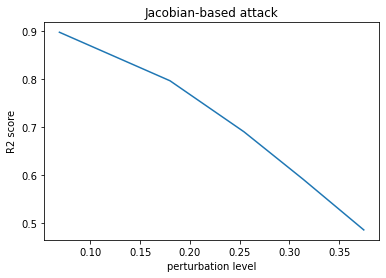

In [35]:
plt.plot(perturb_list,target_list)
plt.xlabel('perturbation level')
plt.ylabel('R2 score')
plt.title('Jacobian-based attack')

# Jacobian-based Saliency Map Attack
1. transform the problem into classification problems

In [36]:
# Classify the data points into differnt categories and transform the problem into classification problems
data_PE.reshape(-1,1)

data_PE_max = max(data_PE)
data_PE_min = min(data_PE)

print(data_PE_max)
print(data_PE_min)

labels = np.zeros(data_PE.shape[0],)

495.76
420.26


In [37]:
for i in range(data_PE.shape[0]):
    if data_PE[i]>420 and data_PE[i]<=440:
        labels[i] = 0
    elif data_PE[i]>440 and data_PE[i]<=460:
        labels[i] = 1
    elif data_PE[i]>460 and data_PE[i]<=480:
        labels[i] = 2
    elif data_PE[i]>480 and data_PE[i]<=500:
        labels[i] = 3


        
labels = torch.tensor(labels)
labels = labels.to(dtype=torch.int64)
Variable(labels)

# scaler = MinMaxScaler()
# data_minmax = scaler.fit_transform(data)
x_data = torch.tensor(data_standard)
Variable(x_data)

X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.33)

x = Variable(X_train)
x.requires_grad = True

In [38]:
# Set up the neural network for classification

class Model_c(torch.nn.Module):
    def __init__(self):
        super(Model_c,self).__init__()
        self.linear1 = torch.nn.Linear(4,32)
        self.dropout = torch.nn. Dropout(p=0.5)
        self.linear2 = torch.nn.Linear(32,32)
        self.dropout = torch.nn. Dropout(p=0.5)
        self.linear3 = torch.nn.Linear(32,16)
        self.dropout = torch.nn. Dropout(p=0.5)
        self.linear4 = torch.nn.Linear(16,16)
        self.dropout = torch.nn. Dropout(p=0.5)
        self.linear5 = torch.nn.Linear(16,16)
        self.dropout = torch.nn. Dropout(p=0.5)
        self.predict = torch.nn.Linear(16,4)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out =self.predict(out)
        out = F.softmax(out)
        return out
    
model_c = Model_c().double()

model_c

Model_c(
  (linear1): Linear(in_features=4, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=16, bias=True)
  (predict): Linear(in_features=16, out_features=4, bias=True)
)

In [39]:
optimizer = torch.optim.SGD(model_c.parameters(),lr= 1e1)
loss_func = torch.nn.CrossEntropyLoss()

lc_list = []


for t in range(1000):
    prediction = model_c(x)
    # print(prediction)
    loss = loss_func(prediction,y_train)

    optimizer.zero_grad()
    loss.backward()
    lc_list.append(loss)
    optimizer.step()




<ipython-input-38-abd5c2567561>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


In [51]:
print(y_train.shape)
print(prediction.shape)

torch.Size([6410])
torch.Size([6410, 4])


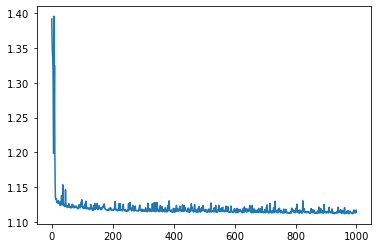

In [40]:
plt.plot(range(1000),lc_list)

In [41]:
# compute the accuracy of the neural network
pred = torch.max(F.softmax(prediction),1)[1]

accuracy = sum(pred.numpy() == y_train.numpy()) *1.0 / y_train.shape[0]
accuracy

<ipython-input-41-e96f743d5482>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.max(F.softmax(prediction),1)[1]


0.6269890795631825

In [42]:
for i in range(pred.shape[0]):
    if pred[i] != y_train[i]:
        print(pred[i],y_train[i])
#         print(y_train[i])
    

tensor(2) tensor(1)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(2)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(2)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)


tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(2)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(2)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)


tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(2)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(2)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(2)
tensor(2) tensor(3)
tensor(2) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(1)


tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(2)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(1)
tensor(2) tensor(3)
tensor(2) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(1) tensor(0)
tensor(1) tensor(0)
tensor(2) tensor(3)
tensor(2) tensor(1)
tensor(2) tensor(1)


In [43]:
prediction = model_c(x)
print(prediction)

tensor([[ 2.4833e-94,  1.0000e+00,  6.1349e-80,  1.0713e-88],
        [6.2171e-132,  1.0000e+00, 2.3162e-112, 5.1910e-124],
        [ 2.5468e-05,  3.7450e-04,  9.9958e-01,  2.2605e-05],
        ...,
        [1.3017e-232,  1.0000e+00, 3.5601e-199, 1.4741e-218],
        [ 1.3207e-11,  8.3246e-10,  1.0000e+00,  8.0624e-12],
        [3.3705e-101,  1.0000e+00,  7.3401e-86,  3.7665e-95]],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)


<ipython-input-38-abd5c2567561>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


# Implementing JSMA attack

In [52]:
def compute_jacobian(model, x):

    output = model(x)
#     print(output.shape)
    num_features = int(np.prod(x.shape[0]))
#     print(num_features)
    jacobian = torch.zeros([num_features,output.size()[0]])
#     print(jacobian.shape)
    mask = torch.zeros(output.size())  # chooses the derivative to be calculated
#     print(mask.shape)
    for i in range(output.size()[0]):
        mask[i] = 1
#         print(mask)
        x.retain_grad()
        output = model(x)
        zero_gradients(x)
        output.backward(mask, retain_graph=True)
        # copy the derivative to the target place
        jacobian[:,i] = x.grad
        mask[i] = 0  # reset
    return jacobian
    
    
    
def saliency(jacobian,y):
    n_in = jacobian.shape[0]
    n_out = jacobian.shape[1]
    saliency_ = torch.zeros([n_in])
#     print(n_in)
#     print(n_out)
#     print(saliency)
    if y == 3:
        t = 2
#     elif y==7:
#         t = 5
    else:
        t = y+1
    for i in range(n_in):
        sum_grad = 0
        for j in range(n_out):
            if j != t:
                sum_grad = sum_grad + jacobian[i,j]
        if jacobian[i,t]<0 or sum_grad>0:
            saliency_[i] = 0
        else:
            saliency_[i] = jacobian[i,t]*torch.abs(sum_grad)
    return saliency_
    

In [53]:
def generating_saliency_map(model,x,y):
    n_samples = x.shape[0]
    n_dim = x.shape[1]
    saliency_map = torch.zeros([n_samples,n_dim])
    print(saliency_map.shape)
    for i in range(n_samples):
        xi = x[i,:]
        yi = y_train[i]
        yp = F.softmax(model_c(xi))
        yp = np.argmax(yp.detach().numpy())
        
        if yi.numpy() == yp:
            jacobian = compute_jacobian(model, xi)
            saliency_sample =saliency(jacobian,yi)
#         print(saliency_sample)
            saliency_map[i,:] = saliency_sample
#         print(saliency_map)
    return saliency_map
        

In [54]:
saliency_map = generating_saliency_map(model_c,x,y_train)
print(saliency_map.shape) 
print(saliency_map)  

torch.Size([6410, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])


<ipython-input-38-abd5c2567561>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)
<ipython-input-53-22809e4ec87c>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yp = F.softmax(model_c(xi))


torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

accuracy_list = [0.7,0.6,0.5,0.4,0.3]

level_list = []
accuracy_ac_list = []

accuracy = 1

x_adv = Variable(X_train)
x_adv.requires_grad = True

for i in accuracy_list:
    n = 0
    while accuracy>i and n<5:
        prediction = model_c(x_adv)
        pred = torch.max(F.softmax(prediction),1)[1]
        accuracy = sum(pred.numpy() == y_train.numpy()) *1.0 / y_train.shape[0]
        saliency_sample = generating_saliency_map(model_c,x_adv,y_train)
        x_adv = x_adv + saliency_sample
        level = np.linalg.norm( X_train.numpy()-x_adv.numpy())/np.linalg.norm(X_train)
        level_list.append(level)
        accuracy_ac_list.append(accuracy)
        n = n+1

In [47]:
perturbation = [0,0.1,0.5,1,5,10,20]

level_list = []
accuracy_list = []

X_train.requires_grad = False

for pert in perturbation:
    x_adv = X_train + pert*saliency_map
    level = np.linalg.norm( pert*saliency_map.numpy(),axis=1,ord = 2).sum()/np.linalg.norm(X_train,axis=1,ord = 2).sum()
    level_list.append(level)
    prediction = model_c(x_adv)
    pred = torch.max(F.softmax(prediction),1)[1]
    accuracy = sum(pred.numpy() == y_train.numpy()) *1.0 / y_train.shape[0]
    
    
    
    accuracy_list.append(accuracy)

print(accuracy_list)
print(level_list)

<ipython-input-38-abd5c2567561>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)
<ipython-input-47-d787090c12c5>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.max(F.softmax(prediction),1)[1]


[0.6302652106084243, 0.6294851794071763, 0.6288611544461779, 0.6287051482059283, 0.6290171606864274, 0.6285491419656787, 0.6285491419656787]
[0.0, 0.0014908345971164554, 0.007454172039859069, 0.014908344079718139, 0.07454172165955497, 0.14908344331910994, 0.2981668866382199]


In [48]:
print(saliency_map)

tensor([[-0.0000e+00, -0.0000e+00, 0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, 0.0000e+00, -0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3588e-19, 1.1643e-21, 2.5204e-22, 2.9208e-23],
        [-0.0000e+00, -0.0000e+00, 0.0000e+00, -0.0000e+00]])
